In [1]:
n_train = 240
n_test = 300

# 源数据准备

## 数据获取

In [2]:
import pandas as pd

In [3]:
stocks = pd.read_parquet('./csmar/stock.parquet.gzip')

In [4]:
raw_data = stocks[['Stkcd','Trddt','Clsprc','Adjprcnd']]
raw_data = raw_data[(raw_data['Trddt']<'2020-01-01')&(raw_data['Trddt'] >= '2017-01-01')]

## 指定待估值大致时间段

In [5]:
ref_time = raw_data['Trddt'].unique()[n_train]
ref_time

'2017-12-26'

In [6]:
end_time = raw_data['Trddt'].unique()[n_train+n_test]
end_time

'2019-03-25'

In [7]:
train_raw_data = raw_data[(raw_data['Trddt'] < ref_time)]
test_raw_data = raw_data[(raw_data['Trddt'] < end_time)&(raw_data['Trddt'] >= ref_time)]

## 指定待估值股票

In [8]:
interested_stock = ['000001', '000002', '000005', '000008', '000009', '000010', '002677']

# 数据预处理

## 数据集生成

In [9]:
from ts.data import Preprocess
from ts.value.data import TrainDataSet, TestDataSet

In [10]:
train_ds = TrainDataSet(
    data=Preprocess.process(
        data=train_raw_data,
        time_column='Trddt',
        id_column='Stkcd',
        price_column='Clsprc'
    ),
    treated_stock_list=interested_stock
)

In [11]:
test_ds = TestDataSet(
    data=Preprocess.process(
        data=test_raw_data,
        time_column='Trddt',
        id_column='Stkcd',
        price_column='Clsprc',
        keepall=True
    )
)

## 待估值股票训练数据准备

In [22]:
train_data = train_ds[-1]

## 待估值股票估值数据准备

In [23]:
test_data = test_ds.infer_from_train(train_data)

# 对待估值股票估值

## 准备模型

In [24]:
import ts.linear.model as linear
from ts.value.model import Value

In [25]:
sc = linear.SynthControl()

In [26]:
value_model = Value(sc)

## 训练估值模型

In [27]:
train_result = value_model.train(train_data)

## 估值模型推断

In [28]:
test_result = value_model.infer(test_data)

In [29]:
result = train_result.extend(test_result)

# 结果可视化

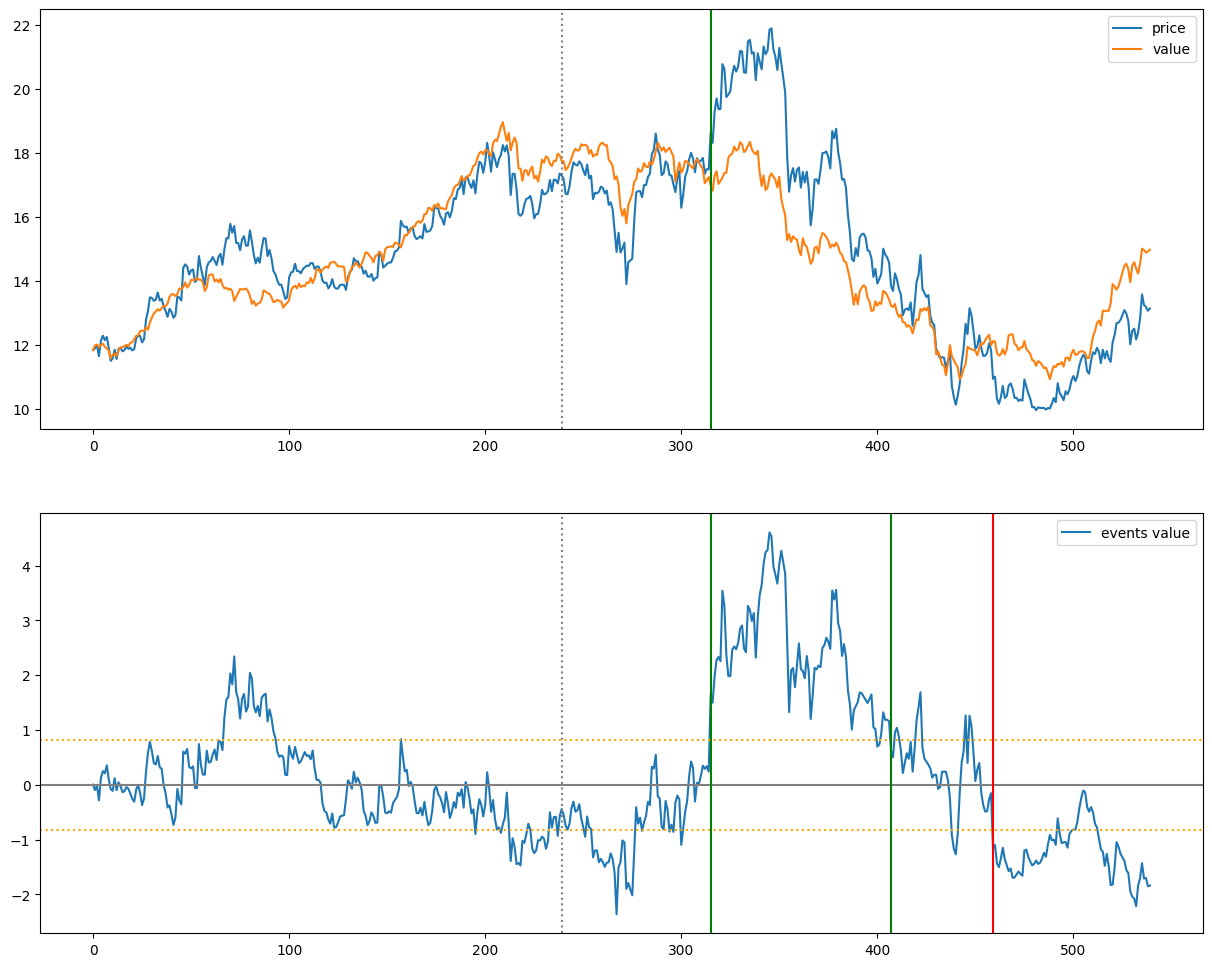

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2,1)
fig.set_figwidth(15)
fig.set_figheight(12)

x_treated = result.x.squeeze()
x_synth = result.x_pred.squeeze()
value = result.value.squeeze()
band = result.band

axes[0].plot(x_treated)
axes[0].plot(x_synth)
axes[0].axvline(n_train-1, linestyle=':', color="gray")
axes[0].annotate('train period ends', 
                #Put label below outcome if pre-treatment trajectory is decreasing, else above
                xy=(n_train-1, 60),
                xytext=(-150, -4),
                xycoords='data',
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
axes[0].legend(['price', 'value'])

axes[1].plot(value)
# axes[1].plot(np.abs(value))
axes[1].axvline(n_train-1, linestyle=':', color="gray")
axes[1].annotate('train period ends', 
                #Put label below outcome if pre-treatment trajectory is decreasing, else above
                xy=(n_train-1, np.quantile(x_treated, 0.9)),
                xytext=(-50, -4),
                xycoords='data',
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
axes[1].axhline(0, c='gray')
axes[1].axhline(-band, linestyle=':', color="orange")
axes[1].axhline(band, linestyle=':', color="orange")
axes[1].legend(['events value'])


from ts.value.metric import find_value_return
vtr = find_value_return(result, n_train)
if vtr.deviation_time:
    axes[0].axvline(vtr.deviation_time, color="green")
    axes[1].axvline(vtr.deviation_time, color="green")
if vtr.return_time:
    # axes[0].axvline(vtr.return_time, color="green")
    # axes[0].axvline(vtr.end_time, color="red")
    axes[1].axvline(vtr.return_time, color="green")
    axes[1].axvline(vtr.end_time, color="red")


In [31]:
result.time[vtr.deviation_time]

'2018-04-20'